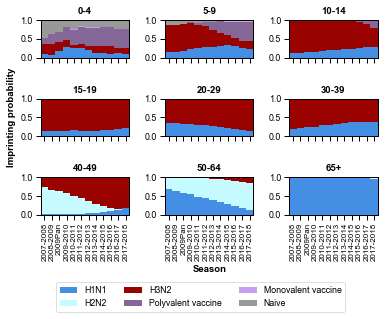

In [1]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

sns.set_context('paper')
rcParams['font.sans-serif'] = 'arial'
imprinting_df = pd.read_csv('../data/vaccine_imprinting_probs.csv', index_col=('Season', 'Birth_year'))
demo_df = pd.read_csv('../data/demography_by_age_extended.csv')

pal = sns.xkcd_palette(['dark sky blue', 'light sky blue', 'deep red', 'dark lavender', 'lavender']).as_hex() + ['#999999']

age_groups =((0, 4),
             (5, 9),
             (10, 14),
             (15, 19),
             (20, 29),
             (30, 39),
             (40, 49),
             (50, 64),
             (65, 100))

def age_to_age_group(age, age_groups):
    ag = np.nan
    for lb, ub in age_groups:
        if age >= lb and age <= ub:
            ag = '-'.join((str(lb), str(ub)))
            break
    return ag

def season_to_label(season):
    if season == '2009.5':
        l = '2009Pan'
    else:
        l = str(int(float(season)) - 1) + '-' + str(int(float(season)))
    return l


for index, row in demo_df.iterrows():
    y1 = row.y1
    y2 = row.y2
    f1 = row.f1
    f2 = row.f2
    age = row.Age
    season = row.Season
    
    i_h1_1 = i_h2_1 = i_h3_1 = i_n_1 = i_v_1 = 0
    i_h1_2 = i_h2_2 = i_h3_2 = i_n_2 = i_v_2 = 0
    if season > 2007 and age <= 100:
        if y1 >= 1918:
            i_h1_1 = imprinting_df.loc[(season, y1), 'H1']
            i_h2_1 = imprinting_df.loc[(season, y1), 'H2']
            i_h3_1 = imprinting_df.loc[(season, y1), 'H3']
            i_v_1 = imprinting_df.loc[(season, y1), 'vac']
            i_pv_1 = imprinting_df.loc[(season, y1), 'panvac']
            i_n_1 = 1 - (i_h1_1 + i_h2_1 + i_h3_1 + i_v_1 + i_pv_1)
            #print(i_h1_1 + i_h2_1 + i_h3_1 + i_n_1)
        if y2 >= 1918:
            i_h1_2 = imprinting_df.loc[(season, y2), 'H1']
            i_h2_2 = imprinting_df.loc[(season, y2), 'H2']
            i_h3_2 = imprinting_df.loc[(season, y2), 'H3']
            i_v_2 = imprinting_df.loc[(season, y2), 'vac']
            i_pv_2 = imprinting_df.loc[(season, y2), 'panvac']
            i_n_2 = 1 - (i_h1_2 + i_h2_2 + i_h3_2 + i_v_2 + i_pv_2)
        
        # Correction since we're just ignoring people who were born before 1918
        if y2 < 1918:
            f1 = 1.0
            f2 = 0.0
        
        if y1 >=1918 or y2 >=1918:
            i_h1 = i_h1_1 * f1 + i_h1_2 * f2
            i_h2 = i_h2_1 * f1 + i_h2_2 * f2
            i_h3 = i_h3_1 * f1 + i_h3_2 * f2
            i_n = i_n_1 * f1 + i_n_2 * f2
            i_v = i_v_1 * f1 + i_v_2 * f2
            i_pv = i_pv_1 * f1 + i_pv_2 * f2
            pop = row.Population * f1 + row.Population * f2
            demo_df.loc[index, 'H1'] = i_h1 * pop
            demo_df.loc[index, 'H2'] = i_h2 * pop
            demo_df.loc[index, 'H3'] = i_h3 * pop
            demo_df.loc[index, 'naive'] = i_n * pop
            demo_df.loc[index, 'vac'] = i_v * pop
            demo_df.loc[index, 'panvac'] = i_pv * pop
            demo_df.loc[index, 'age_group'] = age_to_age_group(age, age_groups)
plot_df = demo_df[~np.isnan(demo_df.H1)].copy()

plot_df['H1N1'] = plot_df['H1']
plot_df['H2N2'] = plot_df['H2']
plot_df['H3N2'] = plot_df['H3']
plot_df['Naive'] = plot_df['naive']
plot_df['Monovalent vaccine'] = plot_df['panvac']
plot_df['Polyvalent vaccine'] = plot_df['vac']

for ag, agdf in plot_df.groupby('age_group'):
    a1 = int(ag.split('-')[0])
    subplot = 1
    for lb, ub in age_groups:
        if lb == a1:
            break
        else:
            subplot += 1
    plt.subplot(3, 3, subplot)
    temp = agdf.copy()
    agg = agdf.groupby('Season')
    agg = agg.sum()
    agg = agg.divide(agg.Population, axis=0)
    agg.plot.bar(y=['H1N1', 'H2N2', 'H3N2', 'Polyvalent vaccine', 'Monovalent vaccine', 'Naive'],
                 stacked=True,
                 width=1,
                 color=pal,
                 ax=plt.gca(),
                 legend = False)
    ticks, labels = plt.xticks()
    plt.gca().set_xlabel('')
    if subplot not in range(len(age_groups)-2 , len(age_groups) + 1):
        plt.xticks(ticks, [])
    else:
        new_labels = [season_to_label(l.get_text()) for l in labels]
        plt.xticks(ticks, new_labels, size=8, rotation=90)
    
    if subplot == 4:
        plt.ylabel('Imprinting probability', weight='bold')
        
    if subplot == 8:
        plt.gca().set_xlabel('Season', weight='bold')
        
    if ag != '65-100':
        plt.title(ag, weight='bold')
    else:
        plt.title('65+', weight='bold')

    plt.xlim(-0.5, len(agg) - 0.5)
    plt.ylim(0, 1)


plt.gcf().set_size_inches(5.5,4)

plt.tight_layout()
plt.legend(loc='center',
           bbox_to_anchor=(-1, -2.2),
           ncol=3)
plt.savefig('../../Marshfield/Flu-A-imprinting-paper/Fig_imprinting_probs_vac.pdf', bbox_inches='tight')

-2.555720759255564


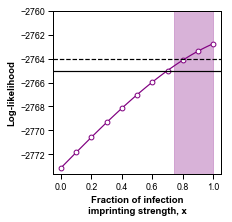

In [11]:
import glob
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import numpy as np
from scipy.interpolate import UnivariateSpline
%matplotlib inline

loglik = pd.read_excel('../vaccine_imprinting/results_from_vm.xlsx')

def caic(ll):
    K = 29
    n = 2181
    return (-2 * -ll + 2*K + ((2*K*(K+1))/(n-K-1))) - 5586.864646840148

def find_caic_cutoff(ll_measured):
    K = 28
    n = 2181
    cAIC_cutoff = (-2 * -ll_measured + 2*K + ((2*K*(K+1))/(n-K-1)))

    for delta_ll in np.arange(0.1, 5, 0.00001):
        K = 29
        ll = ll_measured - delta_ll
        caic = (-2 * -ll + 2*K + ((2*K*(K+1))/(n-K-1)))
        dcaic = caic - cAIC_cutoff
        if dcaic < 0:
            break
    return ll

cutoff = find_caic_cutoff(2765.055)
    
rcParams['font.sans-serif'] = 'arial'
sns.set_context('paper')

print(caic(2762.75))
loglik['cAIC'] = loglik.loglik.apply(caic)
spl = UnivariateSpline(loglik.fh, -loglik.loglik)
plt.plot(np.arange(0, 1, 0.01), spl(np.arange(0, 1, 0.01)), color='purple')
plt.plot(loglik.fh, -loglik.loglik, 'o', markeredgecolor='purple', color='white', label='MLE')


plt.ylabel('Log-likelihood', weight='bold')
plt.xlabel('Fraction of infection\nimprinting strength, x', weight='bold')
plt.gca().axhline(y=-2765.055, linestyle='-', color='black')
plt.gca().axhline(y=-cutoff, linestyle='--', color='black')
ymin, ymax = plt.ylim()
plt.ylim(ymin, -2760)
plt.fill_between(x=[0.74, 1.0], y1=-2800, y2=-2750, color='purple', alpha=0.3)

plt.gcf().set_size_inches(3,3)
plt.savefig('../../Marshfield/Flu-A-imprinting-paper/Fig_XX_Vaccine_Imprinting.pdf', bbox_inches='tight')

In [12]:
def caic(ll):
    K = 28
    n = 2181
    return (-2 * -ll + 2*K + ((2*K*(K+1))/(n-K-1)))
caic(2765.055)

5586.864646840148

In [13]:
for x, l in zip(np.arange(0, 1, 0.01), spl(np.arange(0, 1, 0.01))):
    if l >= -2762.75 - 1.92:
        print(x)
        break

0.74


# Figure 5, S6

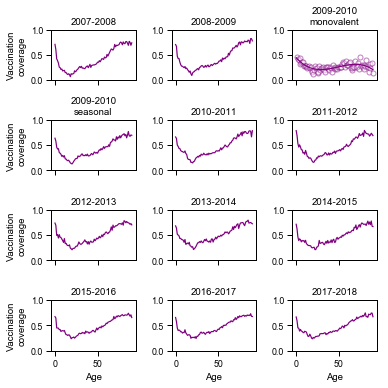

In [9]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy.spatial.distance import pdist, cosine
from scipy import stats
from itertools import combinations, permutations
from scipy.interpolate import splev, splrep
%matplotlib inline

np.random.seed(100)

rcParams['font.sans-serif'] = 'arial'

vac_by_age = pd.read_csv('../raw_data/vac_coverage_by_age_seasonal_2010.csv')
raw_mono = vac_counts = pd.read_csv('../raw_data/monovalent_vaccination_counts.csv')
demo_data = pd.read_csv('../data/demography_by_age_extended.csv')

def age_to_age_class(age):
    for l, u in age_classes:
        if age <= u and age >= l:
            age_class = '-'.join([str(l), str(u)])
            break
    if age_class == '65-200':
        age_class = '65-100'
    return age_class


age_classes = [(0, 4),
               (5, 9),
               (10, 14),
               (15, 19),
               (20, 29),
               (30, 39),
               (40, 49),
               (50, 64),
               (65, 200)]

spl = splrep(vac_counts.age, vac_counts.Coverage, s=5)
interp = splev(range(0, max(vac_counts.age) + 1), spl)
mono_cov = demo_data[(demo_data.Season == 2009.5) &
                      (demo_data.Age <= max(vac_counts.age))].copy()
mono_cov['Vaccinated'] = mono_cov.Population * interp
mono_cov['Unvaccinated'] = mono_cov.Population - mono_cov.Vaccinated
mono_cov['coverage'] = interp
mono_cov['Season'] = '2010'
mono_cov = mono_cov[['Age', 'Season', 'coverage', 'Vaccinated', 'Unvaccinated']]


subplot = 1
for season, seasondf in vac_by_age.groupby('Season'):
    if season == 2010:
        title = '2009-2010\nseasonal'
        subplot += 1
    else:
        title = str(season-1) +'-' + str(season)
    plt.subplot(4, 3, subplot)
    ax = plt.gca()
    seasondf.plot(x='Age', y='coverage', ax=ax, legend=False, color='purple')
    
    ticks, labels = plt.xticks()
    xmin, xmax = plt.xlim()
    if subplot in [1, 4, 7, 10]:
        plt.ylabel('Vaccination\ncoverage')
    if subplot not in [10, 11, 12]:
        plt.xlabel('')
        plt.xticks([0, 50, 100], [])
    else:
        plt.xticks([0, 50, 100], [0, 50, 100])
    plt.xlim(xmin, xmax)
    plt.title(title)
    plt.ylim(0, 1)
    subplot += 1

plt.subplot(4,3,3)
plt.plot(raw_mono.age, raw_mono.Coverage, 'o', alpha=0.5,color='white', markeredgecolor='purple',markersize=5)
mono_cov.plot(x='Age', y='coverage', ax=plt.gca(), color='purple', legend=False)

plt.xlabel('')
ticks, labels = plt.xticks()
xmin, xmax = plt.xlim()
plt.xticks(ticks, [])
plt.xlim(xmin, xmax)
plt.ylim(0, 1)
plt.title('2009-2010\nmonovalent')
plt.gcf().set_size_inches(5.5, 5.5)

plt.tight_layout()

# Figure 5 S7

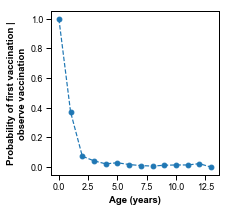

In [15]:
df = pd.read_csv('../raw_data/prob_of_first_vaccination.csv')

rcParams['font.sans-serif'] = 'arial'
sns.set_context('paper')

plt.plot(df.Age, df.probability_first_vaccine, 'o--')
plt.ylabel('Probability of first vaccination |\nobserve vaccination', weight='bold')
plt.xlabel('Age (years)', weight='bold')
plt.gcf().set_size_inches(3,3)
